In [34]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ml_help
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from time import time
sns.set_theme()

In [35]:
metrics_available = os.listdir("./metrics")
METRICS_DONE = "005_gardiner_flow_only_cv_metrics.csv.zip" in metrics_available and "005_gardiner_flow_only_metrics.csv.zip" in metrics_available

# Load data

In [36]:
df = pd.read_csv("./data/gardiner_flow.csv.zip")
df.head(3)

,collectedAt,month,day,day_of_week,hour,minute,currentSpeed
0,2022-07-14 12:45:00+00:00,July,14,Thursday,12,45,94
1,2022-07-14 12:51:44+00:00,July,14,Thursday,12,51,94
2,2022-07-14 12:55:27+00:00,July,14,Thursday,12,55,75


In [37]:
df.drop(["collectedAt"],axis=1,inplace=True)
df.head(3)

,month,day,day_of_week,hour,minute,currentSpeed
0,July,14,Thursday,12,45,94
1,July,14,Thursday,12,51,94
2,July,14,Thursday,12,55,75


In [38]:
categorical_feats = ["month","day_of_week"]

transformed_df = pd.get_dummies(df, columns=categorical_feats)
transformed_df = transformed_df.astype("float32")
transformed_df.head(3)

,day,hour,minute,currentSpeed,month_August,month_December,month_February,month_January,month_July,month_March,month_November,month_October,month_September,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
0,14.0,12.0,45.0,94.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,14.0,12.0,51.0,94.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,14.0,12.0,55.0,75.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [39]:
X = transformed_df.drop("currentSpeed",axis=1)
y = transformed_df["currentSpeed"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Load models

In [40]:
metrics = pd.read_csv("./metrics/004_best_metrics.csv.zip")
metrics

,model,r2,mae,mse,rmse,mape,time_to_fit,time_to_predict
0,XGBoost,0.891815,2.395064,17.909994,4.232020,0.031895,7.480451,0.066916
1,MLP,0.823579,3.336499,29.206305,5.404286,0.044484,94.463218,0.034669
2,Random Forest,0.674519,4.313456,53.250764,7.297312,0.060338,1.001243,0.038121
3,Decision Tree,0.650605,4.353976,57.841973,7.605391,0.061511,0.062577,0.005138


## XGBoost

### Run CV

In [41]:
import xgboost as xgb
        
params = ml_help.params_to_dict("003_xgboost")

In [42]:
params['predictor'] = 'cpu_predictor'
params['tree_method'] = 'hist'

xgboost_pipeline = make_pipeline(StandardScaler(),xgb.XGBRegressor(**params))

if not METRICS_DONE:
    xgb_cv_metrics = ml_help.run_stratified_kfold("XGBoost",xgboost_pipeline,X_train,y_train)
    xgb_cv_metrics

### Test using previously unseen data and get metrics

In [46]:
xgboost_pipeline = make_pipeline(StandardScaler(),xgb.XGBRegressor(**params))

start = time()
pipe = xgboost_pipeline.fit(X_train,y_train)
end = time()

y_pred = pipe.predict(X_test)

xgb_metrics = ml_help.get_metrics_reg("XGBoost",y_test,y_pred)
xgb_metrics["time_to_fit"] = end-start
xgb_metrics

{'model': 'XGBoost',
 'r2': 0.9004587911348009,
 'mae': 2.2896905,
 'mse': 16.034441,
 'rmse': 4.004303,
 'mape': 0.030257514,
 'time_to_fit': 13.74837350845337}

In [47]:
data = X_test.copy(deep=True)
data["Actual"] = y_test
data["Pred."] = y_pred
data.sort_index(inplace=True)
data_dec = data[(data["month_December"] == 1) & (data["day"] == 29)]
data_dec.head()

,day,hour,minute,month_August,month_December,month_February,month_January,month_July,month_March,month_November,...,month_September,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,Actual,Pred.
48230,29.0,0.0,25.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,93.0,91.473862
48234,29.0,0.0,45.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,93.0,93.163925
48235,29.0,0.0,50.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,93.0,93.159882
48236,29.0,0.0,55.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,93.0,93.796326
48243,29.0,1.0,30.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,93.0,93.677811


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


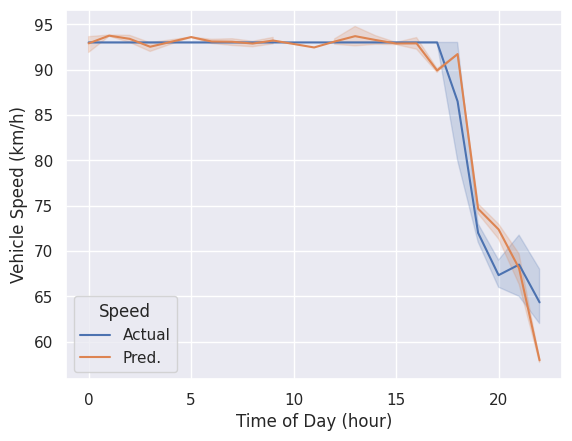

In [48]:
ax = sns.lineplot(data = pd.melt(data_dec[["hour","Actual","Pred."]], ["hour"]), x="hour", y="value", hue="variable")
ax.set(ylabel="Vehicle Speed (km/h)", xlabel="Time of Day (hour)")
ax.get_legend().set_title("Speed")

plt.savefig("./plots/005_xgboost_predictions_per_date.eps", format="eps", bbox_inches="tight")
plt.savefig("./plots/005_xgboost_predictions_per_date.png", bbox_inches="tight")
plt.savefig("./plots/005_xgboost_predictions_per_date.pdf", bbox_inches="tight")

In [11]:
ml_help.plot_prediction(X_test.sort_index(), y_test.sort_index(), y_pred, "XGBoost", "Speed (km/h)", "005_xgboost_predictions")

## Random Forest

### Run CV

In [12]:
if not METRICS_DONE:
    from sklearn.ensemble import RandomForestRegressor
    
    params = ml_help.params_to_dict("003_random_forest")

In [13]:
if not METRICS_DONE:
    random_forest_pipeline = make_pipeline(StandardScaler(),RandomForestRegressor(**params))
    
    random_forest_cv_metrics = ml_help.run_stratified_kfold("Random Forest",random_forest_pipeline,X_train,y_train)
    random_forest_cv_metrics

### Test using previously unseen data and get metrics

In [14]:
if not METRICS_DONE:
    random_forest_pipeline = make_pipeline(StandardScaler(),RandomForestRegressor(**params))
    
    start = time()
    pipe = random_forest_pipeline.fit(X_train,y_train)
    end = time()
    
    y_pred = pipe.predict(X_test)
    
    random_forest_metrics = ml_help.get_metrics_reg("Random Forest",y_test,y_pred)
    random_forest_metrics["time_to_fit"] = end-start
    random_forest_metrics

In [15]:
if not METRICS_DONE:
    ml_help.plot_prediction(y_test, y_pred, "Random Forest", "Speed (km/h)", "005_random_forest_predictions")

## Decision Tree

### Run CV

In [16]:
if not METRICS_DONE:
    from sklearn.tree import DecisionTreeRegressor
    
    params = ml_help.params_to_dict("003_decision_tree")

In [17]:
if not METRICS_DONE:
    decision_tree_pipeline = make_pipeline(StandardScaler(),DecisionTreeRegressor(**params))
    
    dtr_cv_metrics = ml_help.run_stratified_kfold("Decision Tree",decision_tree_pipeline,X_train,y_train)
    dtr_cv_metrics

### Test using previously unseen data and get metrics

In [18]:
if not METRICS_DONE:
    decision_tree_pipeline = make_pipeline(StandardScaler(),DecisionTreeRegressor(**params))
    
    start = time()
    pipe = decision_tree_pipeline.fit(X_train,y_train)
    end = time()
    
    y_pred = pipe.predict(X_test)
    
    dtr_metrics = ml_help.get_metrics_reg("Decision Tree",y_test,y_pred)
    dtr_metrics["time_to_fit"] = end-start
    dtr_metrics

In [19]:
if not METRICS_DONE:
    ml_help.plot_prediction(y_test, y_pred, "Decision Tree", "Speed (km/h)", "005_decision_tree_predictions")

## MLP

### Run CV

In [20]:
if not METRICS_DONE:
    from sklearn.neural_network import MLPRegressor
    
    params = ml_help.params_to_dict("003_mlpr")

In [21]:
if not METRICS_DONE:
    mlp_pipeline = make_pipeline(StandardScaler(),MLPRegressor(**params))
    
    mlp_cv_metrics = ml_help.run_stratified_kfold("MLP",mlp_pipeline,X_train,y_train)
    mlp_cv_metrics

### Test using previously unseen data and get metrics

In [22]:
if not METRICS_DONE:
    mlp_pipeline = make_pipeline(StandardScaler(),MLPRegressor(**params))
    
    start = time()
    pipe = mlp_pipeline.fit(X_train,y_train)
    end = time()
    
    y_pred = pipe.predict(X_test)
    
    mlp_metrics = ml_help.get_metrics_reg("MLP",y_test,y_pred)
    mlp_metrics["time_to_fit"] = end-start
    mlp_metrics

In [23]:
if not METRICS_DONE:
    ml_help.plot_prediction(y_test, y_pred, "MLP", "Speed (km/h)", "005_mlp_predictions")

# Store metrics

In [24]:
if not METRICS_DONE:
    metrics_cv = pd.concat([pd.DataFrame(xgb_cv_metrics,index=[0]),pd.DataFrame(random_forest_cv_metrics,index=[0]),pd.DataFrame(dtr_cv_metrics,index=[0]),pd.DataFrame(mlp_cv_metrics,index=[0])])
    metrics_cv.to_csv("./metrics/005_gardiner_flow_only_cv_metrics.csv.zip",index=False,compression="zip")
    
    metrics = pd.concat([pd.DataFrame(xgb_metrics,index=[0]),pd.DataFrame(random_forest_metrics,index=[0]),pd.DataFrame(dtr_metrics,index=[0]),pd.DataFrame(mlp_metrics,index=[0])])
    metrics.to_csv("./metrics/005_gardiner_flow_only_metrics.csv.zip",index=False,compression="zip")
else:
    metrics_cv = pd.read_csv("./metrics/005_gardiner_flow_only_cv_metrics.csv.zip")
    metrics = pd.read_csv("./metrics/005_gardiner_flow_only_metrics.csv.zip")

# Print CV metrics

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


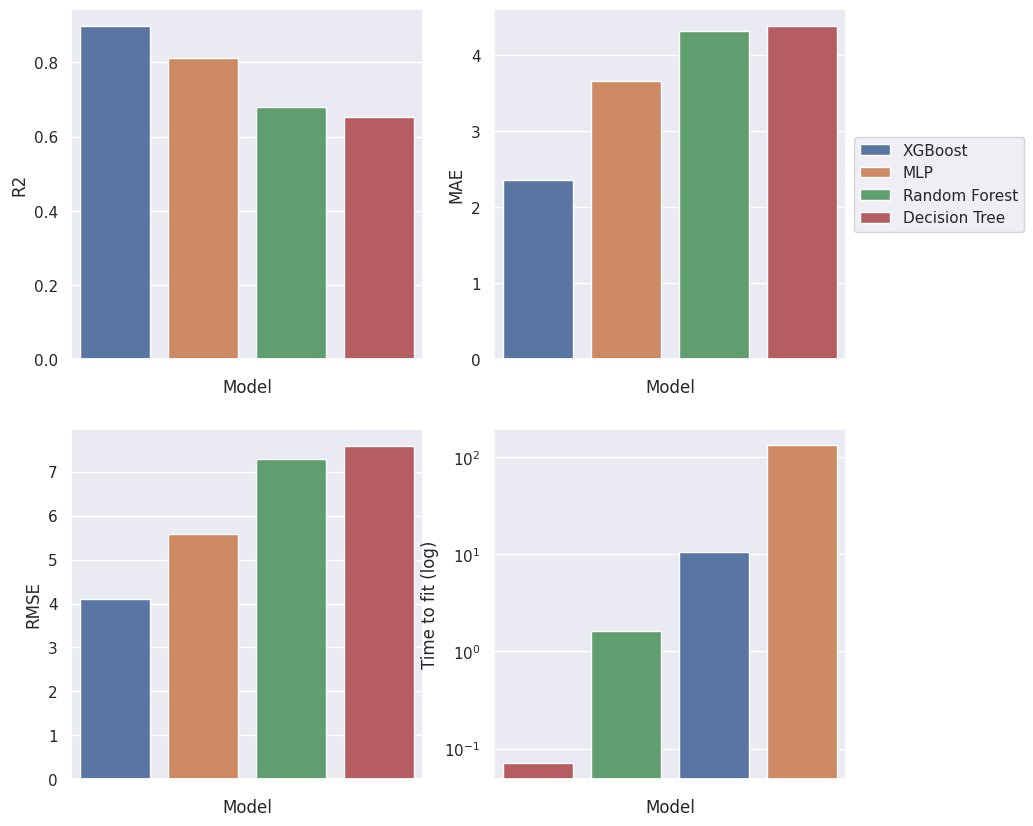

In [43]:
metrics_cv.sort_values(by="r2", inplace=True, ascending=False)
metrics.sort_values(by="r2", inplace=True, ascending=False)
ttf_order_cv = list(metrics_cv.sort_values(by="time_to_fit")["model"])
ttf_order = list(metrics.sort_values(by="time_to_fit")["model"])

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

sns.barplot(ax=axes[0, 0], data=metrics_cv, x='model', y='r2',hue="model",dodge=False)
sns.barplot(ax=axes[0, 1], data=metrics_cv, x='model', y='mae',hue="model",dodge=False)
# sns.barplot(ax=axes[0, 2], data=metrics_cv, x='model', y='mse',hue="model",dodge=False)
sns.barplot(ax=axes[1, 0], data=metrics_cv, x='model', y='rmse',hue="model",dodge=False)
# sns.barplot(ax=axes[1, 1], data=metrics_cv, x='model', y='mape',hue="model",dodge=False)
sns.barplot(ax=axes[1, 1], data=metrics_cv, x='model', y='time_to_fit',hue="model",dodge=False, order=ttf_order_cv)

axes[0, 0].set(xlabel="Model",xticklabels=[])
axes[0, 0].set(ylabel="R2")
axes[0, 0].get_legend().remove()

axes[0, 1].set(xlabel="Model",xticklabels=[])
axes[0, 1].set(ylabel="MAE")
axes[0, 1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

# axes[0, 2].set(xlabel="Model",xticklabels=[])
# axes[0, 2].set(ylabel="MSE")
# axes[0, 2].legend(loc='center left', bbox_to_anchor=(1, 0.5))

axes[1, 0].set(xlabel="Model",xticklabels=[])
axes[1, 0].set(ylabel="RMSE")
axes[1, 0].get_legend().remove()

# axes[1, 1].set(xlabel="Model",xticklabels=[])
# axes[1, 1].set(ylabel="MAPE")
# axes[1, 1].get_legend().remove()

axes[1, 1].set(xlabel="Model",xticklabels=[])
axes[1, 1].set(ylabel="Time to fit (log)",yscale="log")
axes[1, 1].get_legend().remove()

plt.savefig("./plots/005_gardiner_flow_only_cv_metrics.eps",format="eps",bbox_inches="tight")
plt.savefig("./plots/005_gardiner_flow_only_cv_metrics.png",bbox_inches="tight")
plt.savefig("./plots/005_gardiner_flow_only_cv_metrics.pdf",bbox_inches="tight")

# Print metrics

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


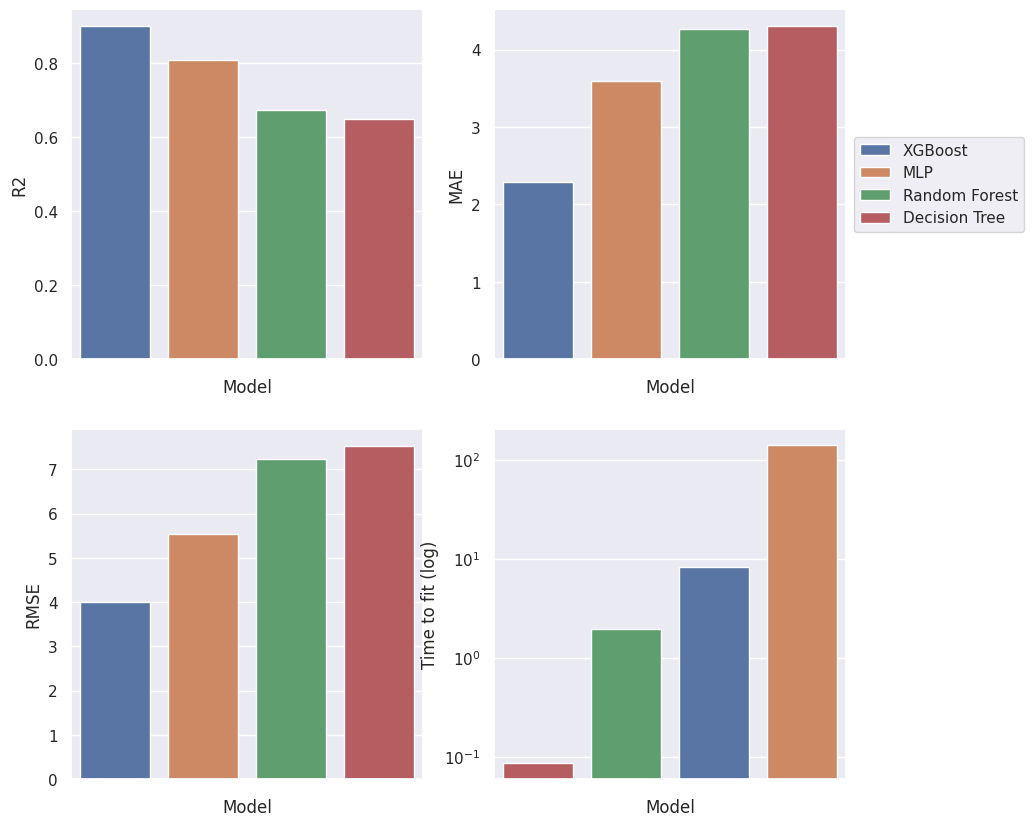

In [44]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

sns.barplot(ax=axes[0, 0], data=metrics, x='model', y='r2',hue="model",dodge=False)
sns.barplot(ax=axes[0, 1], data=metrics, x='model', y='mae',hue="model",dodge=False)
# sns.barplot(ax=axes[0, 2], data=metrics, x='model', y='mse',hue="model",dodge=False)
sns.barplot(ax=axes[1, 0], data=metrics, x='model', y='rmse',hue="model",dodge=False)
# sns.barplot(ax=axes[1, 1], data=metrics, x='model', y='mape',hue="model",dodge=False)
sns.barplot(ax=axes[1, 1], data=metrics, x='model', y='time_to_fit',hue="model",dodge=False, order=ttf_order)

axes[0, 0].set(xlabel="Model",xticklabels=[])
axes[0, 0].set(ylabel="R2")
axes[0, 0].get_legend().remove()

axes[0, 1].set(xlabel="Model",xticklabels=[])
axes[0, 1].set(ylabel="MAE")
axes[0, 1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

# axes[0, 2].set(xlabel="Model",xticklabels=[])
# axes[0, 2].set(ylabel="MSE")
# axes[0, 2].legend(loc='center left', bbox_to_anchor=(1, 0.5))

axes[1, 0].set(xlabel="Model",xticklabels=[])
axes[1, 0].set(ylabel="RMSE")
axes[1, 0].get_legend().remove()

# axes[1, 1].set(xlabel="Model",xticklabels=[])
# axes[1, 1].set(ylabel="MAPE")
# axes[1, 1].get_legend().remove()

axes[1, 1].set(xlabel="Model",xticklabels=[])
axes[1, 1].set(ylabel="Time to fit (log)",yscale="log")
axes[1, 1].get_legend().remove()

plt.savefig("./plots/005_gardiner_flow_only_metrics.eps",format="eps",bbox_inches="tight")
plt.savefig("./plots/005_gardiner_flow_only_metrics.png",bbox_inches="tight")
plt.savefig("./plots/005_gardiner_flow_only_metrics.pdf",bbox_inches="tight")

In [34]:
metrics[["model","r2","mae","rmse","time_to_fit"]]

,model,r2,mae,rmse,time_to_fit
0,XGBoost,0.900459,2.289690,4.004303,8.325927
3,MLP,0.809207,3.597680,5.543783,140.306772
1,Random Forest,0.674429,4.265196,7.241830,1.943558
2,Decision Tree,0.648236,4.305998,7.527505,0.085728
